In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from tqdm.auto import tqdm

In [3]:
# configure user
user = "jonas"  # set this to mitchel

if user.lower() == "jonas":
    BASE_PATH = "/users/jonvdrdo/jonas/data/aaa_contextaware/raw/uz_study/"
elif user.lower() == "mitchel":
    BASE_PATH = "D:/Data/EEG_Study_1/"  # Go check 1_audio_preprocess.py
DATA_PATH = BASE_PATH + "aligned_data"

if user.lower() == "jonas":
    FEATURES_PATH = ""  # + "/features_gemaps/"
elif user.lower() == "mitchel":
    FEATURES_PATH = DATA_PATH + "/features/"

# sequential IBI

In [9]:
feedback_list = []

for p in tqdm(sorted(Path(DATA_PATH).iterdir())):
    if not p.is_dir():
        continue

    timeline_file = p.joinpath("timeline_aligned.csv")
    marker_file = p.joinpath("marker_edf_aligned.csv")

    if timeline_file.exists() and marker_file.exists():
        edf_source = "edf_aligned"

        # 1. if both files exists, read them and parse the time columns
        last_timeline_file = timeline_file
        df_timeline = (
            pd.read_csv(timeline_file).iloc[:, 1:].drop(columns=["OnsetDelay.1"])
        )
        df_marker = pd.read_csv(marker_file).iloc[:, 1:]

        tz = "europe/brussels"
        for c in ["t_start", "t_stop"]:
            df_timeline[c] = pd.to_datetime(df_timeline[c]).dt.tz_convert(tz)
        for c in ["timestamp"]:
            df_marker[c] = pd.to_datetime(df_marker[c]).dt.tz_convert(tz)

        # 2. assert whether the start-time of the timeline file is sorted
        df_timeline = df_timeline.sort_values(by=["t_start", "Trial"])
        assert df_timeline["t_start"].is_monotonic_increasing

        # 3. Add some additional columns
        df_timeline["prev_Phase"] = df_timeline.Phase.shift(1)
        df_timeline["RESP"] = df_timeline.RESP.shift(1)  # slide response
        df_timeline["CRESP"] = df_timeline.CRESP.shift(1)  # correct slide response
        df_timeline["answered_in_time"] = df_timeline.RESP.notna()
        df_timeline["answered_correctly"] = df_timeline.RESP == df_timeline.CRESP
        df_timeline[
            "delay_slide_feedback"
        ] = df_timeline.t_start - df_timeline.t_stop.shift(1)

        # 4. filter on the feedback events
        df_feedback = df_timeline[
            df_timeline.Phase.str.lower().str.contains("feedback")
        ].copy()

        df_feedback["user"] = p.name
        df_feedback["edf_source_dir"] = edf_source

        # assert that all the previous phases were example slides
        assert all(df_feedback["prev_Phase"].str.lower().str.contains("slide"))
        feedback_list.append(df_feedback)

    elif True:
        pass
        # TODO -> extend with non-aligned files

# construct the feedback dataframe
df_feedback = pd.concat(feedback_list, axis=0, ignore_index=True)

# omit the files which have a delay larger than max_slide_delay
# NOTE: don't do this, as these are the ones who did not answer in time
# max_slide_delay = pd.Timedelta(seconds=0.1)
# print(sum(df_feedback.delay_slide_feedback > max_slide_delay))
# df_feedback = df_feedback[df_feedback.delay_slide_feedback < max_slide_delay]

# show the data
df_feedback.iloc[:, np.r_[0:4, df_feedback.shape[1] - 6 : df_feedback.shape[1]]]

  0%|          | 0/85 [00:00<?, ?it/s]

,Phase,Trial,Block,t_start,prev_Phase,answered_in_time,answered_correctly,delay_slide_feedback,user,edf_source_dir
0,Controle1Feedback,1.0,4,2020-02-10 10:41:11.346047+01:00,Controle1Slide,True,False,0 days 00:00:00.066000,16,edf_aligned
1,Controle1Feedback,2.0,4,2020-02-10 10:41:53.776047+01:00,Controle1Slide,True,True,0 days 00:00:00.067000,16,edf_aligned
2,Controle1Feedback,3.0,4,2020-02-10 10:42:46.723047+01:00,Controle1Slide,True,True,0 days 00:00:00.057000,16,edf_aligned
3,Controle1Feedback,4.0,4,2020-02-10 10:43:02.689047+01:00,Controle1Slide,True,True,0 days 00:00:00.064000,16,edf_aligned
4,Controle1Feedback,5.0,4,2020-02-10 10:43:23.621047+01:00,Controle1Slide,True,False,0 days 00:00:00.069000,16,edf_aligned
...,...,...,...,...,...,...,...,...,...,...
3380,Stress3FeedBack,24.0,5,2020-09-18 10:34:54.476813+02:00,Stress3Slide,True,True,0 days 00:00:00.063000,83,edf_aligned
3381,Stress3FeedBack,25.0,5,2020-09-18 10:35:10.892813+02:00,Stress3Slide,True,True,0 days 00:00:00.072000,83,edf_aligned
3382,Stress3FeedBack,26.0,5,2020-09-18 10:36:55.117813+02:00,Stress3Slide,True,False,0 days 00:00:00.082000,83,edf_aligned
3383,Stress3FeedBack,27.0,5,2020-09-18 10:37:21.215813+02:00,Stress3Slide,False,False,0 days 02:10:44.947000,83,edf_aligned


In [5]:
left_slice_margin_s = 6
right_slice_margin_s = 7
min_r_peak_threshold = 0.9


# ------------------- HYPERPARAMS -------------------
# the first item exceeding this threshold will set at IBI pos 0
time_threshold = 0
reference_ibi_pos = -4

# iterate over all the users in the feedback file
slcs = []
for user in tqdm(df_feedback.user.unique()):
    df_f_user = df_feedback[df_feedback.user == user]

    # fetch the correct feedback RR_interval data (matching timestamps)
    f_path = Path(DATA_PATH).joinpath(user, df_f_user.edf_source_dir.values[0])
    f_path = list(f_path.glob("rr_intervals_*.parquet"))
    if len(f_path) != 1:
        print(f"skipping user {user} f_path size {len(f_path)}")
        continue

    rr_file_user = pd.read_parquet(f_path[0]).set_index("timestamp")

    for idx, r in df_f_user.iterrows():
        t_start = r.t_start - pd.Timedelta(seconds=left_slice_margin_s)
        t_end = r.t_start + pd.Timedelta(seconds=right_slice_margin_s)
        slc = rr_file_user[t_start:t_end].copy().reset_index()

        # do not use slices with lower
        if not len(slc) or any(slc["r_peak_agreement"] <= min_r_peak_threshold):
            continue

        # add a relative time col w.r.t. event and feedback_index which will be used
        # to link the data back to df_feedback
        slc["rel_event_time"] = (slc.timestamp - r.t_start).dt.total_seconds()
        slc["feedback_index"] = idx

        # determine the int-ibi pos
        slc["IBI_pos"] = slc.index - slc[slc.rel_event_time > time_threshold].index[0]
        slc["RR_delta_ms"] = (
            slc.RR_interval_ms
            - slc[slc.IBI_pos == reference_ibi_pos].RR_interval_ms.values[0]
        )

        slcs.append(slc)

df_slc = pd.concat(slcs, axis=0, ignore_index=True)
del slcs

  0%|          | 0/58 [00:00<?, ?it/s]

## Viusalizations

### Per trial & group

In [ ]:
# visualizing the ibi delta
fig_list = []
for trial in tqdm(sorted(df_feedback.Trial.unique())):
    shown_groups = []
    fig = go.Figure()
    for group in ["Controle", "Stress"]:
        rr_group = []
        df_f_gr = df_feedback[
            (df_feedback["Procedure[Block]"] == group) & (df_feedback.Trial == trial)
        ]
        for feeback_idx, _ in df_f_gr.iterrows():
            rr_d = (
                df_slc[df_slc["feedback_index"] == feeback_idx]
                .copy()
                .set_index("IBI_pos")
                .sort_index()["RR_delta_ms"]
            )
            rr_group.append(rr_d)

        df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False)
        rr_group_mean = df_rr_group.mean(axis=1)
        rr_group_std = df_rr_group.std(axis=1)
        fig.add_trace(
            go.Scattergl(
                x=rr_group_mean.index,
                y=rr_group_mean,
                error_y=dict(type="data", array=rr_group_std, visible=True),
                mode="markers+lines",
                name=group + f" n= {df_rr_group.shape[1]}",
                legendgroup=group,
                showlegend=group not in shown_groups,
            )
        )
        shown_groups.append(group)

    fig.update_layout(height=400, title=f"feedback - trial {trial}", title_x=0.5)
    fig.update_xaxes(title_text="Sequential IBI")
    fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) (ms)")
    fig.show()
    fig_list.append(fig)

# from context_aware.visualizations.plotly import figs_to_html
# figs_to_html(fig_list, 'trial_sequential_ibi.html')

### Per group & answered-in time

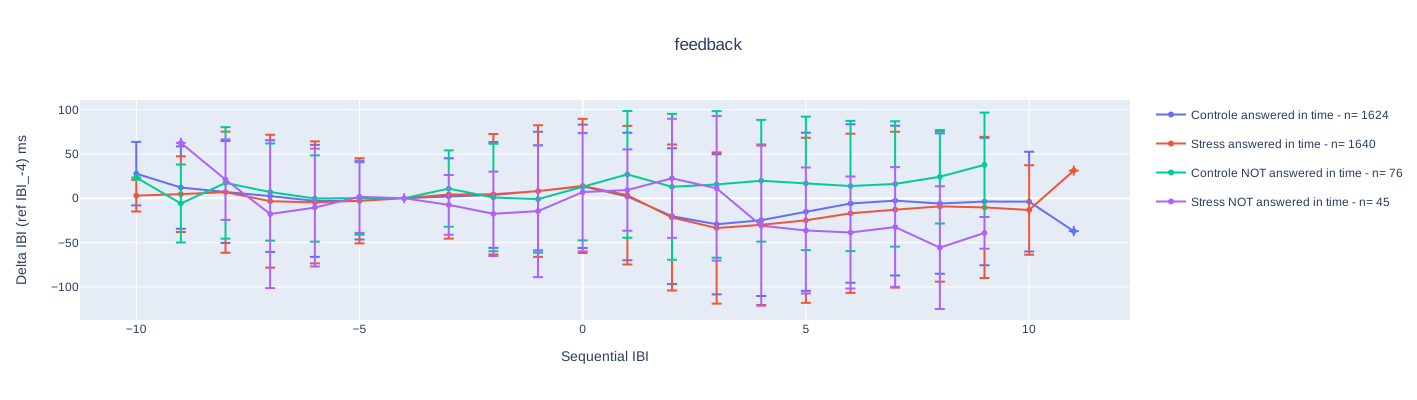

In [7]:
fig_list = []
fig = go.Figure()
for answer_in_time in [True, False]:
    shown_groups = []
    for group in ["Controle", "Stress"]:
        rr_group = []
        df_f_gr = df_feedback[
            (df_feedback["Procedure[Block]"] == group)
            & (df_feedback.answered_in_time == answer_in_time)
        ]
        for feeback_idx, _ in df_f_gr.iterrows():
            rr_d = (
                df_slc[df_slc["feedback_index"] == feeback_idx]
                .copy()
                .set_index("IBI_pos")
                .sort_index()["RR_delta_ms"]
            )
            rr_group.append(rr_d)

        df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False)
        rr_group_mean = df_rr_group.mean(axis=1)
        rr_group_std = df_rr_group.std(axis=1)
        fig.add_trace(
            go.Scattergl(
                x=rr_group_mean.index,
                y=rr_group_mean,
                error_y=dict(type="data", array=rr_group_std, visible=True),
                mode="markers+lines",
                name=group
                + f"{' NOT' if not answer_in_time else ''} answered in time - n= {df_rr_group.shape[1]}",
                legendgroup=group + str(answer_in_time),
                showlegend=group not in shown_groups,
            )
        )
        shown_groups.append(group)

fig.update_layout(height=400, title=f"feedback", title_x=0.5)
fig.update_xaxes(title_text="Sequential IBI")
fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) ms")

### Per group & answered correctly

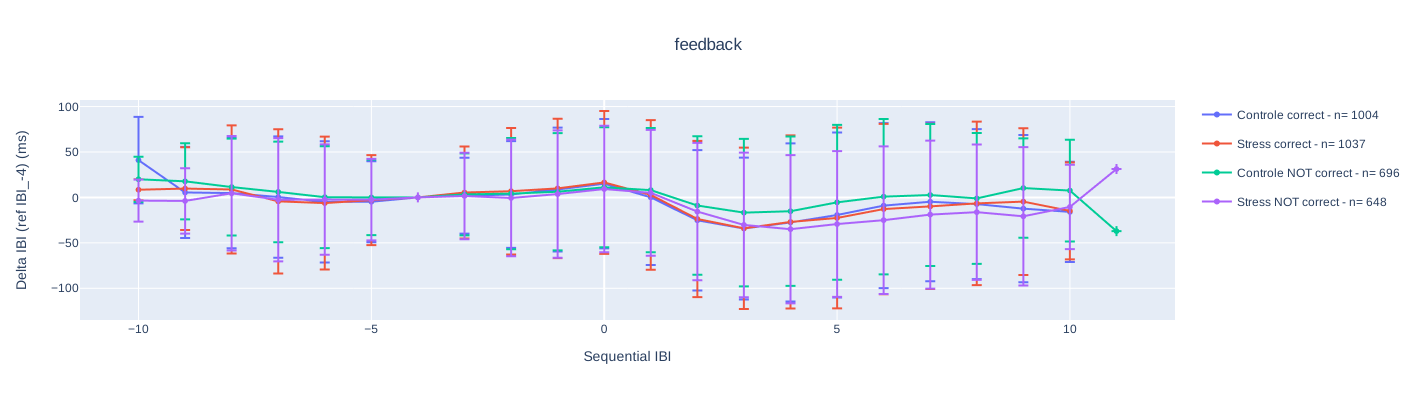

In [8]:
fig_list = []
fig = go.Figure()
for answered_correctly in [True, False]:
    shown_groups = []
    for group in ["Controle", "Stress"]:
        rr_group = []
        df_f_gr = df_feedback[
            (df_feedback["Procedure[Block]"] == group)
            & (df_feedback.answered_correctly == answered_correctly)
        ]
        for feeback_idx, _ in df_f_gr.iterrows():
            rr_d = (
                df_slc[df_slc["feedback_index"] == feeback_idx]
                .copy()
                .set_index("IBI_pos")
                .sort_index()["RR_delta_ms"]
            )
            rr_group.append(rr_d)

        df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False)
        rr_group_mean = df_rr_group.mean(axis=1)
        rr_group_std = df_rr_group.std(axis=1)
        fig.add_trace(
            go.Scattergl(
                x=rr_group_mean.index,
                y=rr_group_mean,
                error_y=dict(type="data", array=rr_group_std, visible=True),
                mode="markers+lines",
                name=group
                + f"{' NOT' if not answered_correctly else ''} correct - n= {df_rr_group.shape[1]}",
                legendgroup=group + str(answered_correctly),
                showlegend=group not in shown_groups,
            )
        )
        shown_groups.append(group)

fig.update_layout(height=400, title=f"feedback", title_x=0.5)
fig.update_xaxes(title_text="Sequential IBI")
fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) (ms)")
fig.show()